In [12]:
import osmnx as ox
import geopandas as gpd
import math
import numpy as npm
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from rtree.index import Index as RTreeIndex
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
from collections import deque
import datetime
from tqdm import tqdm
import networkx as nx

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [13]:
CRS_LATLON = 'EPSG:4326'
DATA_DIR = '../../../data'
EXPORTS_DIR = f'{DATA_DIR}/exports'
LIB_DIR = '../../lib'
LOG_DIR = '../../../log'

In [14]:
UNSUPPORTED_ROUTES = [
    'M35',
    'M60+',
]

In [15]:
road_mg = ox.load_graphml(f'{EXPORTS_DIR}/graphml/manhattan/road.graphml')

In [16]:
def get_geoms(G):
    return ox.utils_graph.graph_to_gdfs(G, nodes=False)['geometry']

def get_rtree(G, geoms):
    # build the r-tree spatial index by position for subsequent iloc
    rtree = RTreeIndex()
    for pos, bounds in enumerate(geoms.bounds.values):
        rtree.insert(pos, bounds)
    return rtree

road_geoms = get_geoms(road_mg)
road_rtree = get_rtree(road_mg, road_geoms)

In [17]:
routes_gdf = gpd.read_file(
    f'{EXPORTS_DIR}/shp/manhattan/bus_routes_nyc_may2020.shp', crs=CRS_LATLON)
routes_gdf = routes_gdf.to_crs(CRS_LATLON)

# Remove unsupported routes.
routes_gdf = routes_gdf[~routes_gdf['route_id'].isin(UNSUPPORTED_ROUTES)]

In [18]:
def get_k_nearest_edges(rtree, geoms, x, y, k=6):
    # use r-tree to find possible nearest neighbors, one point at a time,
    # then minimize euclidean distance from point to the possible matches
    xy = (x, y)
    dists = geoms.iloc[list(rtree.nearest(xy, num_results=k))].distance(Point(xy))
    dists_df = pd.DataFrame([a[0][0:2] + (a[1],) for a in zip(dists.index, dists)], columns=['u', 'v', 'dist'])
    return dists_df.nsmallest(k, 'dist', keep='first').reset_index(drop=True)

In [19]:
def get_all_kne_linked_paths(G, knes, path_threshold=10):
    all_paths = []
    all_paths_set = set()

    for k in tqdm(range(0, len(knes) - 1)):
        knes0 = knes[k]
        knes1 = knes[k + 1]
        for i in range(0, len(knes0)):
            for j in range(0, len(knes1)):
                n0u = knes0.loc[i, 'u']
                n0v = knes0.loc[i, 'v']
                n1u = knes1.loc[j, 'u']
                n1v = knes1.loc[j, 'v']
                
                path0 = ox.distance.shortest_path(G, n0v, n1u)
                path1 = ox.distance.shortest_path(G, n1v, n0u)
                
                for path in [path0, path1]:
                    if path is None or len(path) < 2:
                        continue
                
                    if len(path) < path_threshold:
                        hash_path = str(path)
                        if hash_path not in all_paths_set:
                            all_paths.append(path)
                            all_paths_set.add(hash_path)
    return all_paths

In [26]:
def get_all_kne_linked_edges(all_kne_linked_paths):
    all_edges = []
    all_edges_set = set()
    
    for path in all_kne_linked_paths:
        for i in range(0, len(path) - 1):
            edge = [path[i], path[i + 1]]
            hash_edge = str(edge)
            if hash_edge not in all_edges_set:
                all_edges.append(edge)
                all_edges_set.add(hash_edge)
                
    return all_edges

In [27]:
def create_subgraph(G, edges):
    node_set = set()
    graph = nx.MultiDiGraph()
    
    for edge in edges:
        u = edge[0]
        v = edge[1]
        if u not in node_set:
            node_set.add(u)
            graph.add_node(u, **G.nodes[u])
        if v not in node_set:
            node_set.add(v)
            graph.add_node(v, **G.nodes[v])
        graph.add_edge(u, v)
        
    graph.graph['crs'] = CRS_LATLON
    return graph

In [37]:
class Tracer:

    def __init__(self, geometry=None, road_rtree=None, road_geoms=None, road_mg=None):
        self.point_knes = [
            get_k_nearest_edges(road_rtree, road_geoms, c[0], c[1])
            for c in tqdm(geometry.coords)
        ]
        
        all_kne_linked_paths = get_all_kne_linked_paths(road_mg, self.point_knes)
        all_kne_linked_edges = get_all_kne_linked_edges(all_kne_linked_paths)
        
        subgraph_edges = [] 
        subgraph_edges_set = set()
        
        for edge in all_kne_linked_edges:
            edge_hash = str(edge)
            if edge_hash not in subgraph_edges_set:
                subgraph_edges.append(edge)
                subgraph_edges_set.add(edge_hash)
                
        self.subgraph = create_subgraph(road_mg, subgraph_edges)

In [38]:
tracer = Tracer(geometry=routes_gdf.loc[1, 'geometry'],
                road_geoms=road_geoms,
                road_rtree=road_rtree,
                road_mg=road_mg)

100%|██████████| 271/271 [00:00<00:00, 550.12it/s]


In [39]:
trace_route_subgraph = tracer.subgraph

In [40]:
ox.distance.add_edge_lengths(trace_route_subgraph)

In [41]:
dist_attrs = {}
count_attrs = {}
weight_attrs = {}

for edge in trace_route_subgraph.edges:
    dist_attrs[edge] = 1
    count_attrs[edge] = 0
    
for entry in tracer.point_knes:
    for i, row in entry.iterrows():
        key = (int(row['u']), int(row['v']), 0)
        if key not in dist_attrs:
            dist_attrs[key] = 1
            count_attrs[key] = 0
        dist_attrs[key] = min(dist_attrs[key], row['dist'])
        if row['dist'] < 0.00001:
            count_attrs[key] += 1
    
max_count = max(count_attrs.values())
display(max_count)
        
for key in dist_attrs.keys():
    weight_attrs[key] = dist_attrs[key]
        
nx.set_edge_attributes(trace_route_subgraph, weight_attrs, name='kne_weight')

0

In [42]:
def get_k_nearest_edges(rtree, geoms, x, y, k=6, threshold=10):
    # use r-tree to find possible nearest neighbors, one point at a time,
    # then minimize euclidean distance from point to the possible matches
    xy = (x, y)
    dists = geoms.iloc[list(rtree.nearest(xy, num_results=k))].distance(Point(xy))
    dists_df = pd.DataFrame([a[0][0:2] + (a[1],) for a in zip(dists.index, dists)], columns=['u', 'v', 'dist'])
    dists_df['dist'] *= (0.11 / 0.000001)
    dists_df = dists_df.nsmallest(k, 'dist', keep='first')
    dists_df = dists_df[dists_df['dist'] < threshold]
    return dists_df.reset_index(drop=True)

In [43]:
def get_edge_colors(mg, attr, threshold=0.5, cmap='Reds'):
    """Modified OSMNX function to center the values such that zero is 50% of the
    colormap. Useful for comparing positive/negative values where a neutral
    color in a divergent colormap corresponding to 0 is desired."""
    start = 0
    stop = 1
    na_color = '#333'
    
    values = pd.Series(nx.get_edge_attributes(mg, attr))
    
    values_min = 0#values.dropna().min()
    values_max = values.dropna().max()
    
    # Reduce extent by threshold amount such that everything above it is maximum
    # (or below negative is minimum), i.e. truncate the colormap range.
    max_extent = max(abs(values_min), abs(values_max)) * threshold
    abs_min = 0
    abs_max = max_extent
    
    full_range = (abs_max - abs_min) / (stop - start)
    full_min = abs_min - full_range * start
    full_max = full_min + full_range

    # linearly map a color to each attribute value
    normalizer = colors.Normalize(full_min, full_max)
    scalar_mapper = cm.ScalarMappable(normalizer, cm.get_cmap(cmap))
    color_series = values.map(scalar_mapper.to_rgba)
    color_series.loc[values == -9] = '#0ff'
    color_series.loc[pd.isnull(values)] = na_color
    
    return color_series

In [44]:
def haversine(c1, c2):
    lat1 = math.radians(c1[1])
    lon1 = math.radians(c1[0])
    lat2 = math.radians(c2[1])
    lon2 = math.radians(c2[0])
    dist_lon = lon2 - lon1
    dist_lat = lat2 - lat1

    a = (math.sin(dist_lat / 2)**2 +
         math.cos(lat1) * math.cos(lat2) * math.sin(dist_lon / 2)**2)
    c = 2 * math.asin(math.sqrt(a))
    km = 6371 * c
    return 1000 * km

In [45]:
count_attrs = {}
weight_attrs = {}

last_coord = None
skips = 0
used_coords = []

for coord in tqdm(tracer.geometry.coords):
    if last_coord and haversine(coord, last_coord) < 50:
        skips += 1
        continue
    last_coord = coord
    used_coords.append(coord)
    
    edge_df = get_k_nearest_edges(road_rtree, road_geoms, coord[0], coord[1], k=25, threshold=20)
    for i, edge_row in edge_df.iterrows():
        key = (int(edge_row['u']), int(edge_row['v']), 0)
        if key not in count_attrs:
            count_attrs[key] = 0
        count_attrs[key] += (20 - edge_row['dist'])
       
print(skips / len(trace.coords))

NameError: name 'trace' is not defined

In [314]:
K = 5
for edge in tracer.subgraph.edges:
    weight_attrs[edge] = nx.get_edge_attributes(trace_route_subgraph, 'length')[edge]
    if edge in count_attrs:
        weight_attrs[edge] = 1 / (K * count_attrs[edge] + 1)
    else:
        count_attrs[edge] = 0
     

In [315]:
debug_df = get_k_nearest_edges(road_rtree, road_geoms, tracer.geometry.coords[103][0], tracer.geometry.coords[103][1], k=25, threshold=20)
debug_edges = []
for i, debug_row in debug_df.iterrows():
    key = (int(debug_row['u']), int(debug_row['v']), 0)
    count_attrs[key] = -9
display(debug_df)

,u,v,dist
0,42427780,7395403290,1.104377
1,7395403290,42427780,1.104377
2,7395403286,42427780,1.402438
3,42427780,7395403286,1.402438
4,7395403287,42427780,2.019332
5,42427780,7395403287,2.019332
6,7395403290,7395403289,6.943799
7,7395403289,7395403290,6.943799
8,7395403290,6882325995,6.953540
9,5883468679,7395403290,6.953540


In [316]:
nx.set_edge_attributes(trace_route_subgraph, count_attrs, name='kne_count')
nx.set_edge_attributes(trace_route_subgraph, weight_attrs, name='kne_weight')

In [317]:
edge_colors = get_edge_colors(trace_route_subgraph, 'kne_count')

In [318]:
start_coord = trace.coords[0]
start_edge = get_k_nearest_edges(road_rtree, road_geoms, start_coord[0], start_coord[1], k=1)
end_coord = trace.coords[-1]
end_edge = get_k_nearest_edges(road_rtree, road_geoms, end_coord[0], end_coord[1], k=1)

start_node_id = start_edge.loc[0, 'u']
end_node_id = end_edge.loc[0, 'v']

In [319]:
path = nx.dijkstra_path(trace_route_subgraph, start_node_id, end_node_id, weight='kne_weight')

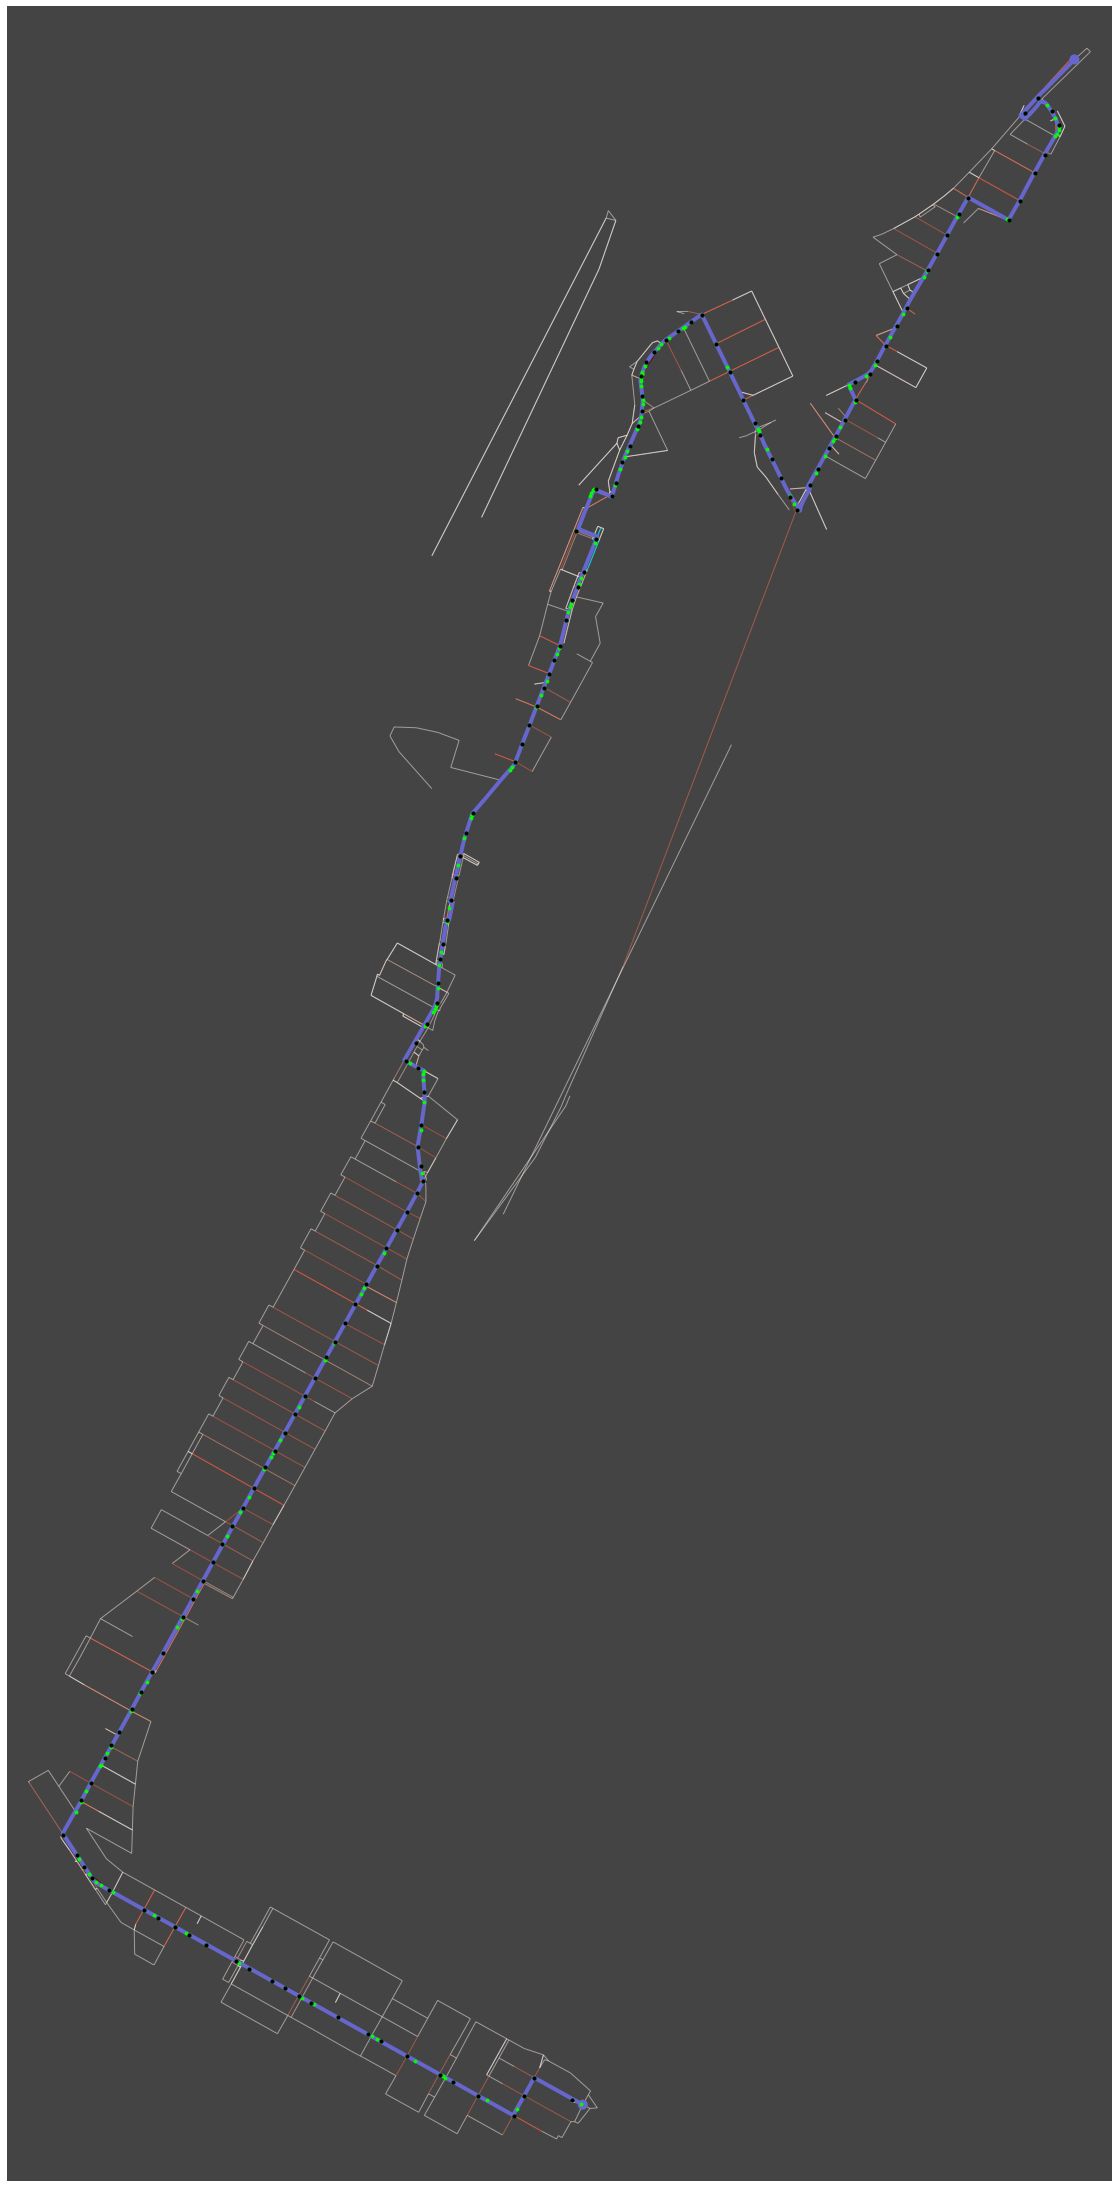

In [321]:
fig, ax = plt.subplots(figsize=(40, 40))

#ox.plot_graph(road_mg,
#              ax=ax,
#              bgcolor='#444',
#              node_size=0,
#              show=False,
#              close=False,
#              edge_color='#3a3a3a')

ox.plot_graph(trace_route_subgraph,
              ax=ax,
              bgcolor='#444',
              node_size=0,
              show=False,
              close=False,
              edge_color=edge_colors,
              edge_linewidth=1,
              edge_alpha=0.5)

ox.plot_graph_route(road_mg,
                    path,
                    ax=ax,
                    bgcolor='#444',
                    node_size=0,
                    show=False,
                    close=False,
                    route_color='#66c',
                    edge_linewidth=5,
                    route_alpha=1.0,
                    zorder=3)

gpd.GeoDataFrame({},
                 geometry=[Point(c[0], c[1]) for c in trace.coords],
                 crs=CRS_LATLON).plot(ax=ax, markersize=8, color='#0f0', zorder=4)
gpd.GeoDataFrame({},
                 geometry=[Point(c[0], c[1]) for c in used_coords],
                 crs=CRS_LATLON).plot(ax=ax, markersize=10, color='#000', zorder=4)
#k = 103 
#gpd.GeoDataFrame({},
#                 geometry=[Point(c[0], c[1]) for c in trace.coords[k:k+1]],
#                 crs=CRS_LATLON).plot(ax=ax, markersize=100, color='#f0f', zorder=4)

ax.set_facecolor('#444')
plt.show()

In [253]:
sg_geoms = get_geoms(trace_route_subgraph)
sg_rtree = get_rtree(trace_route_subgraph, sg_geoms)